In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import joblib
import pickle
import time
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA
import xgboost as xgb

c:\Users\haile\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Loading data

In [3]:
train=pd.read_csv("C:/Users/haile/OneDrive - University of Bristol/assessment2/data_cleaned_full_text_and_summaries.csv")


In [5]:
def myprocess(thisdoc):
    ## Runs on documents (vector of words)
    return(thisdoc.strip('[]').replace("u'", '').replace("'", '').replace(' ', '').split(','))
#train['text']= train['text'].apply(lambda x: x.map(myprocess))
train['text']=train['text'].map(myprocess)

In [6]:
train

,Unnamed: 0,text,sentiment
0,0,"[not, good, buy, book, read, glow, praise, onl...",0
1,1,"[buyer, beware, self, publish, book, want, kno...",0
2,2,"[bad, complete, waste, time, typographical, er...",0
3,3,"[please, guess, romance, novel, lover, one, no...",0
4,4,"[awful, beyond, belief, feel, write, keep, oth...",0
...,...,...,...
2399967,2399994,"[collingwood, famous, book, highly, recommend,...",1
2399968,2399995,"[original, philosophy, history, englishman, co...",1
2399969,2399996,"[excellent, edition, collingwood, art, fine, e...",1
2399970,2399997,"[magnificent, book, motivate, enough, collingw...",1


In [7]:
train.isna().sum()

Unnamed: 0    0
text          0
sentiment     0
dtype: int64

## Comment on w2v model vs d2v model

We have started with trying out both w2v and d2v models, and comparing their performance with fixed classification models with the same parameters. The code for the d2v model can be found in Hailey's folder.
After comparison, we decided that w2v works better, so we perform the hyperparameter tuning on the w2v model and also on the classification model with inputs from a w2v model.

## Fit the w2v model

Here we try to get the w2v model to work on dataset.

Define some parameters for a w2v model and fit our data set into the model.

In [8]:
vector_size=100
#The number of dimensions of embeddings, the default is 100
window=3
#The maximum distance between a target word and its neighbours, default is 5
min_count=3
#The minimum counts of words in order for the word to be considered for the training of model, default is 5
workers=3
#The number of partitions during training, default is 3
sg=1
#The training algorithom, either CBOW(0) or skip gram(1), default is CBOW

#tokens = pd.Series(df['tokenized_text']).values
start_t = time.time()
w2vmodel=Word2Vec(train['text'],min_count=min_count,vector_size=vector_size,workers=workers,sg=sg)
print('Time taken to train word2vec model:' +str(time.time()-start_t))

Time taken to train word2vec model:7508.7082278728485


In [9]:
word2vec_model_file = 'C:/Users/haile/OneDrive - University of Bristol/assessment2' + 'w2v_full' + '.model'
w2vmodel.save(word2vec_model_file)

In [10]:
w2v_model = Word2Vec.load(word2vec_model_file) 
#we have to save and load for some of the function below to work

## Extract the outputs of w2v model

https://towardsdatascience.com/word2vec-explained-49c52b4ccb71

how to put the outputs of word2vec into data frame, and apply PCA on the outputs

In [21]:
emb_df = (
    pd.DataFrame(
        [w2v_model.wv.get_vector(str(n)) for n in w2vmodel.wv.key_to_index],
        index = w2vmodel.wv.key_to_index
    )
)
print(emb_df.shape)

emb_df.head()

(36738, 1000)


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
book,0.211522,0.109768,-0.086857,0.113861,-0.023535,-0.049067,0.043023,0.107938,-0.133363,-0.022978,...,-0.050999,0.074128,0.018453,0.078004,-0.000211,-0.049173,-0.197556,-0.068898,0.037838,-0.055804
not,0.073117,-0.027324,0.027492,0.065707,-0.154759,0.016292,-0.067428,0.009653,-0.056164,0.019808,...,-0.041710,-0.087962,0.028281,0.079893,0.055188,-0.045373,-0.029655,-0.064627,0.060643,0.051575
read,0.104907,0.027842,-0.140540,0.073859,-0.082279,0.025850,-0.004111,0.076974,-0.045041,0.023919,...,0.002090,0.074155,-0.112637,0.004727,0.088765,0.059001,-0.113064,-0.172981,0.151946,-0.035543
one,0.155092,0.029189,0.014406,-0.028765,-0.025418,-0.051278,0.105640,0.060942,-0.095715,-0.049613,...,-0.093852,0.051328,0.022567,0.067211,-0.004432,-0.027067,-0.011083,-0.116765,0.077796,-0.047839
story,0.263330,-0.097268,-0.104919,0.057629,0.001288,-0.001956,0.075879,-0.014131,-0.065047,0.014728,...,0.101535,-0.007435,0.018824,-0.005728,0.066427,0.010958,-0.087800,0.043413,0.140598,-0.084432


In [11]:
print(w2v_model.wv.most_similar('wonderful'))

[('marvelous', 0.8957252502441406), ('fabulous', 0.8849557042121887), ('fantastic', 0.8827628493309021), ('terrific', 0.8636866807937622), ('great', 0.8146536350250244), ('splendid', 0.8033068776130676), ('amazing', 0.8001943826675415), ('delightful', 0.7995973229408264), ('amaze', 0.7977790832519531), ('wondeful', 0.7922130823135376)]


In [12]:
print("Cosine similarity between 'wonderful' " +
               "terrible' - Skip Gram : ",
    w2v_model.wv.similarity('wonderful', 'bad'))

Cosine similarity between 'wonderful' terrible' - Skip Gram :  0.29368404


## load pretrained model

In [13]:
from gensim.models import KeyedVectors

pretrained_path = "C:/Users/haile/OneDrive - University of Bristol/assessment2/glove_model2.txt"
model_2 = KeyedVectors.load_word2vec_format(pretrained_path, binary=False)
#model_2.save('C:/Users/haile/OneDrive - University of Bristol/assessment2/glove_model.model')
w2v_model.build_vocab([list(model_2.index_to_key)], update=True)
training_examples_count = w2v_model.corpus_count
w2v_model.train(train['text'],total_examples=training_examples_count, epochs=w2v_model.epochs)


KeyboardInterrupt: 

## Compute feature vectors for each review

https://www.kaggle.com/code/varun08/sentiment-analysis-using-word2vec/notebook
 define functions to compute feature vectors, which is an average of the vectors of each word appeared in the review, and the feature vectors can be then be used as inputs for the classification model.

In [23]:
# Function to average all word vectors in a paragraph
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index_to_key)
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model.wv[word])
    
    if nwords ==0:
        featureVec = np.zeros(1000)
        #avoiding divide by zero, define it as a all zero vector
    else:
        featureVec = np.divide(featureVec, nwords)
    # Dividing the result by number of words to get average

    return featureVec

In [24]:
# Function for calculating the average feature vector
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        # Printing a status message every 1000th review
        if counter%1000 == 0:
            print("Comment %d of %d"%(counter,len(reviews)))
            
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
            
        counter = counter+1
        
    return reviewFeatureVecs

The two functions above will raise an error message of dividing by 0 if nwords=0, this is because the wv2 model has min_count set to 3, sometimes all the words appearing in a review turn out to have count less than 3, this could be due to spelling errors and various other reasons.

Therefore, I have added a line of if boolean in the featureVecMethod function, which set the vector to all zeros when nwords=0. And it can be then identified later.

In [ ]:
X_train=train
y_train=train['sentiment']

In [118]:
trainDataVecs = getAvgFeatureVecs(X_train['text'], w2v_model, 100)
#get feature vectors for train data

Comment 0 of 40000
Comment 1000 of 40000
Comment 2000 of 40000
Comment 3000 of 40000
Comment 4000 of 40000
Comment 5000 of 40000
Comment 6000 of 40000
Comment 7000 of 40000
Comment 8000 of 40000
Comment 9000 of 40000
Comment 10000 of 40000
Comment 11000 of 40000
Comment 12000 of 40000
Comment 13000 of 40000
Comment 14000 of 40000
Comment 15000 of 40000
Comment 16000 of 40000
Comment 17000 of 40000
Comment 18000 of 40000
Comment 19000 of 40000
Comment 20000 of 40000
Comment 21000 of 40000
Comment 22000 of 40000
Comment 23000 of 40000
Comment 24000 of 40000
Comment 25000 of 40000
Comment 26000 of 40000
Comment 27000 of 40000
Comment 28000 of 40000
Comment 29000 of 40000
Comment 30000 of 40000
Comment 31000 of 40000
Comment 32000 of 40000
Comment 33000 of 40000
Comment 34000 of 40000
Comment 35000 of 40000
Comment 36000 of 40000
Comment 37000 of 40000
Comment 38000 of 40000
Comment 39000 of 40000


In [27]:
trainDataVecs.dump('Data/trainDataVecs')

In [28]:
trainDataVecs=pd.read_pickle('Data/trainDataVecs')

In [136]:
def remove_unuseful_rows(trainDataVecs,y_train):
    list=[]
    y_train.reset_index()
    for i in range(trainDataVecs.shape[0]):
        if np.all(trainDataVecs[i,]==0):
            list.append(i)
    if len(list)!=0:
        trainDataVecs=np.delete(trainDataVecs,list,axis=0)
        y_train.drop(index=list,inplace=True)
    return trainDataVecs,y_train
# remove the sample with all zero vector and its corresponding y

In [141]:
trainDataVecs1,y_train1=remove_unuseful_rows(trainDataVecs,y_train)

In [142]:
y_train1.shape

(39999, 2)

In [143]:
trainDataVecs1.shape

(39999, 1000)

## Classification models

In this section, we train two classification models random forest and xgboost on our train data, we want to compare the their performance on a test data set latter.

In [41]:
xgb_model = xgb.XGBClassifier(
    max_depth = 9, 
    min_child_weight = 1, 
    gamma = 0.4, 
    subsample=0.9, 
    colsample_bytree = 0.9,
    learning_rate =0.2,
    n_estimators=300)


start_time = time.time()
xgb_model.fit(trainDataVecs1, y_train1["sentiment"])
print("Time taken to fit the demodel with word2vec vectors: " + str(time.time() - start_time))

Time taken to fit the demodel with word2vec vectors: 497.33065605163574


https://xgboost.readthedocs.io/en/stable/python/python_api.html
information about xgboost

In [42]:
filename='xgb_model1.joblib'
joblib.dump(xgb_model,filename)

['xgb_model1.joblib']

In [43]:
xgb_model=joblib.load('xgb_model1.joblib')

## Test data set

We start with process the test data set just like we did for the train data, i.e. compute feature vectors, remove rows that divide by zero, and etc.

In [45]:
testDataVecs = getAvgFeatureVecs(X_test['text'], w2v_model, 1000)

Comment 0 of 10000
Comment 1000 of 10000
Comment 2000 of 10000
Comment 3000 of 10000
Comment 4000 of 10000
Comment 5000 of 10000
Comment 6000 of 10000
Comment 7000 of 10000
Comment 8000 of 10000
Comment 9000 of 10000


In [46]:
y_test=y_test.reset_index(drop=True)

In [47]:
testDataVecs1,y_test1=remove_unuseful_rows(testDataVecs,y_test)

In [50]:
xgb_prediction=xgb_model.predict(testDataVecs1)

In [52]:
np.dot(xgb_prediction-y_test1['sentiment'],xgb_prediction-y_test1['sentiment'])

1293

In [54]:
print(classification_report(y_test['sentiment'],xgb_prediction))

              precision    recall  f1-score   support

           0       0.76      0.51      0.61      1995
           1       0.89      0.96      0.92      8005

    accuracy                           0.87     10000
   macro avg       0.83      0.74      0.77     10000
weighted avg       0.86      0.87      0.86     10000



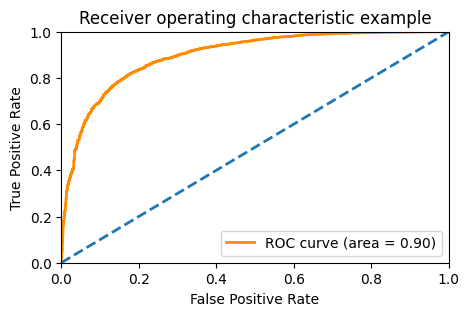

In [56]:
y_pred = [x[1] for x in xgb_model.predict_proba(testDataVecs1)]
fpr, tpr, thresholds = roc_curve(y_test['sentiment'], y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (5, 3))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

All the metrics that I used above suggests that xgboost works better with the w2v model on our data set than the random forest.

## Grid Search

https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost

In [100]:
#params = deepcopy(default_params)

param_grid = {
        'min_child_weight': [1, 5,10],
        'max_depth': [7,9],
        'gamma': [0.5, 1]
        }

# just for checking if grid search works

In [ ]:
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5,7,9,11],
        'learning_rate': [0.2,0.05]
        }

#use this grid on hpc

In [101]:
estimator = xgb.XGBClassifier(n_estimators=300, objective='binary:logistic',learning_rate =0.2, 
    subsample=0.9, 
    colsample_bytree = 0.9,)

In [90]:
trainDataVecs1.shape

(39999, 1000)

In [91]:
y_train1['sentiment'].values

array([1, 1, 0, ..., 1, 1, 1])

In [103]:
eval_set = [(trainDataVecs1,y_train1['sentiment'].values)]
model = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=3, scoring="roc_auc")

start_time = time.time()

model.fit(trainDataVecs1,y_train1['sentiment'].values, verbose=0)

print("Time taken for random search: " + str(time.time() - start_time))

Time taken for random search: 11845.541232824326


In [146]:
print(model.best_params_)

{'gamma': 0.5, 'max_depth': 7, 'min_child_weight': 5}


### Try tuned parameters

In [109]:
tuned_xgb_model = xgb.XGBClassifier(
    max_depth = 7, 
    min_child_weight = 5, 
    gamma = 0.5, 
    subsample=0.9, 
    colsample_bytree = 0.9,
    learning_rate =0.2,
    n_estimators=300)


start_time = time.time()
tuned_xgb_model.fit(trainDataVecs1, y_train1["sentiment"])
print("Time taken to fit the demodel with word2vec vectors: " + str(time.time() - start_time))

Time taken to fit the demodel with word2vec vectors: 396.04686403274536


In [110]:
tuned_xgb_prediction=tuned_xgb_model.predict(testDataVecs1)

In [111]:
np.dot(tuned_xgb_prediction-y_test1['sentiment'],tuned_xgb_prediction-y_test1['sentiment'])

1262

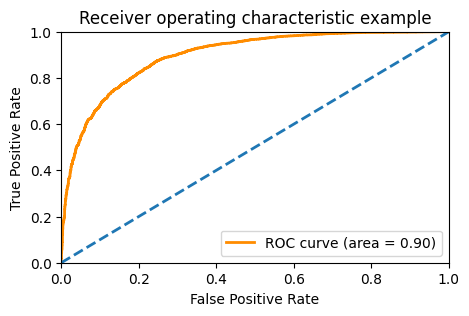

In [113]:
y_pred = [x[1] for x in tuned_xgb_model.predict_proba(testDataVecs1)]
fpr, tpr, thresholds = roc_curve(y_test['sentiment'], y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (5, 3))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Random Search

In [115]:
#params = deepcopy(default_params)

param_grid = {
        'min_child_weight': [1, 5,10],
        'max_depth': [7,9],
        }

# just for checking if grid search works

In [114]:
estimator = xgb.XGBClassifier(n_estimators=300, objective='binary:logistic',learning_rate =0.2, gamma=0.4,
    subsample=0.9, 
    colsample_bytree = 0.9,)

In [116]:
rs_model=RandomizedSearchCV(estimator=estimator,param_distributions=param_grid,n_iter=3,scoring='roc_auc',n_jobs=-1,cv=3,verbose=3)

In [117]:
rs_model.fit(trainDataVecs1,y_train1['sentiment'])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 2/3] END ...max_depth=7, min_child_weight=5;, score=0.892 total time=36.1min
[CV 3/3] END ...max_depth=7, min_child_weight=5;, score=0.889 total time=36.1min
[CV 1/3] END ...max_depth=7, min_child_weight=5;, score=0.892 total time=36.2min
[CV 1/3] END ..max_depth=9, min_child_weight=10;, score=0.896 total time=38.9min
[CV 2/3] END ..max_depth=9, min_child_weight=10;, score=0.892 total time=39.1min
[CV 2/3] END ...max_depth=9, min_child_weight=1;, score=0.891 total time=44.4min
[CV 3/3] END ...max_depth=9, min_child_weight=1;, score=0.889 total time=44.4min
[CV 1/3] END ...max_depth=9, min_child_weight=1;, score=0.893 total time=44.5min
[CV 3/3] END ..max_depth=9, min_child_weight=10;, score=0.892 total time=26.4min


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=0.9,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=0.4, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0...
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=300, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'max_depth': [7, 9],
                                        'min_child_weight': [1, 5, 10]},
                   scoring='roc_auc', verbose=3)

In [144]:
rs_model.best_params_

{'min_child_weight': 10, 'max_depth': 9}

https://www.kaggle.com/code/willkoehrsen/intro-to-model-tuning-grid-and-random-search

Due to the size of the data set and the time constraint, since we want to search over a large range of hyperparameters rather than finding an exact optima in a small range of hyperprarameters, we will perform a random search on a subset of the data set, and then tuning our hyperparameters for working on the whole data set.

If we have more time, we can then perform grid search on a reduced parameter grid, in order to get better performance.